In [1]:
#import libraries
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhure\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhure\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#load the files
csv_file_path1 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/all-data.csv"
csv_file_path2 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/RoBERTaWeaklyLabelling.csv"
try:
    df1 = pd.read_csv(csv_file_path1, encoding='utf-8')
except UnicodeDecodeError:
    df1 = pd.read_csv(csv_file_path1, encoding='latin1')
try:
    df2 = pd.read_csv(csv_file_path2, encoding='utf-8')
except UnicodeDecodeError:
    df2 = pd.read_csv(csv_file_path2, encoding='latin1')

In [4]:
# Concatenate dataframes
if set(df1.columns) == set(df2.columns):
    df = pd.concat([df1, df2], ignore_index=True)
else:
    column_mapping = {'news': 'news', 'label': 'label'}
    df2 = df2.rename(columns=column_mapping)
    df = pd.concat([df1, df2], ignore_index=True)

df.dropna(inplace=True)

In [5]:
df['label'] = df['label'].apply(lambda x: x.lower())

In [6]:
# Preprocessing
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()

In [7]:
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'<.*?>', '', text)    # remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # remove non-alphabetic characters
    text = text.lower()  # convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # remove stopwords
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])  # lemmatization
    return text

df['news'] = df['news'].apply(preprocess_text)

In [8]:
# Label encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
X_train, X_test, y_train, y_test = train_test_split(df['news'], df['label'], test_size=0.2, random_state=42)

In [9]:
#create pipeline for selecting best parameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])


In [10]:
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Unigrams, Bigrams, and Trigrams
    'tfidf__max_df': [0.75, 0.85, 1.0],  # Max document frequency
    'tfidf__min_df': [1, 2, 3],  # Min document frequency
    'nb__alpha': [0.01, 0.1, 1.0, 10.0],  # Smoothing parameter for Naive Bayes
}

In [11]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.01, 0.1, 1.0, 10.0],
                         'tfidf__max_df': [0.75, 0.85, 1.0],
                         'tfidf__min_df': [1, 2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy', verbose=1)

In [12]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'nb__alpha': 0.1, 'tfidf__max_df': 0.75, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}


In [13]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [14]:
print(f'Accuracy: {accuracy:.4f}')
print(report)

Accuracy: 0.7288
              precision    recall  f1-score   support

           0       0.72      0.63      0.67      3491
           1       0.80      0.65      0.72      5253
           2       0.69      0.84      0.76      6566

    accuracy                           0.73     15310
   macro avg       0.74      0.71      0.72     15310
weighted avg       0.74      0.73      0.73     15310



Negative has the lowest recall, meaning the model misses more 'negative' instances.

Neutral has the highest precision, indicating that predictions of 'neutral' are more accurate, but recall is lower compared to 'positive'.

Positive has the highest recall, capturing the most instances of 'positive', but has the lowest precision.

Overall, the model achieves an accuracy of 73%. 

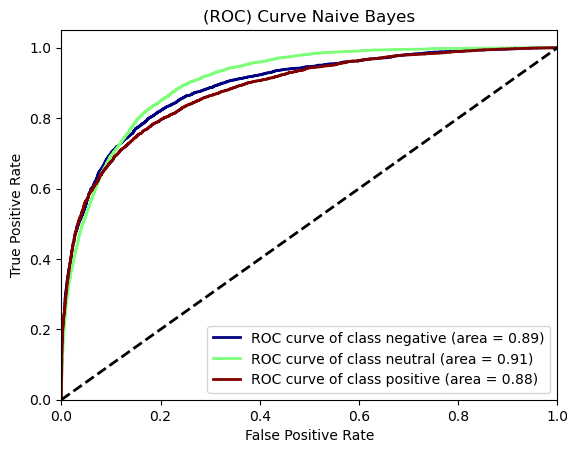

In [16]:
# ROC Curve Plotting
y_score = best_model.predict_proba(X_test)

# Binarize the labels
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
colors = plt.cm.jet(np.linspace(0, 1, n_classes))
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve Naive Bayes')
plt.legend(loc="lower right")
plt.show()

The ROC curve for Naïve Bayes is less prominent compared to the advanced models, reflecting its more basic approach to classification. The curve still shows reasonable performance but is not as robust as the above-mentioned top-performing models.